# Transfer Learning
The dataset used is [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). The neural network used for the first part of the project is [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

## Imports & settings

In [1]:
import os
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np


In [2]:
DEVICE = 'cuda'      # 'cuda' or 'cpu'

NUM_CLASSES = 102    # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

Adjusted hyperparameters

In [3]:
# startings:
LR = 1e-3           
NUM_EPOCHS = 100

# BEST PARAMETERS:
LR = 0.01
NUM_EPOCHS = 40

## Data Preprocessing

In the official documentation of pretrained models on torchvision there is the following piece of code:

    for model_name in __all__: 
        means[model_name] = [0.485, 0.456, 0.406]
        stds[model_name] = [0.229, 0.224, 0.225]

So I set the *transorms.Normalize* mean and standard deviation as defined here

In [4]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet Mean and SD
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet Mean and SD                                 
])

Data Augmentation:

In [5]:
list_degrees = [10,30]

In [6]:
train_transform = transforms.Compose([# transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      # transforms.RandomRotation(degrees=list_degrees),
                                      # transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),  # Imagenet standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])  # Imagenet standards
                                  ])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #ImageNet Mean and SD                                 
])

### Preparing the dataset

In [7]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/luciainnocenti/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes , val_indexes = train_dataset.__getSubsets__(50)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9314, done.
remote: Total 9314 (delta 0), reused 0 (delta 0), pack-reused 9314
Receiving objects: 100% (9314/9314), 129.62 MiB | 40.92 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (9150/9150), done.
Train Dataset: 3045
Valid Dataset: 3093
Test Dataset: 2893


### Preparing the Dataloaders

In [8]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Network set-up

### Non-pretrained Network

In [9]:
net = alexnet() # Loading AlexNet model
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d


### Pretrained Network

To improve performance, use a pretrained model.
Let's see how AlexNet is defined:

In [10]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)
alexNet

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Train last Layer

Now we use AlexNet and we modify only the last layer, that will be trained by the train section:

In [11]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

# Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

# Modify the last layer. It will be trained
alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

### Train FC layers

Use a pretrained AlexNet by un-freezing all the Fully Connetted Layers

In [12]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

# Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

# Unfreeze all the FC layers:
alexNet.classifier[4] = nn.Linear(4096, 4096)
alexNet.classifier[5] = nn.ReLU(inplace=True)
alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

### Train not-FC layers

Use a pretrained AlexNet by un-freezing all the non-Fully Connetted Layers

In [13]:
from torchvision import models
alexNet = models.alexnet(pretrained=True)

# Freeze all the parameters in alexNet
for param in alexNet.parameters():
    param.requires_grad = False

# Unfreeze all the nonFC layers:
alexNet.classifier[0] = nn.Dropout(p=0.5, inplace=False)
alexNet.classifier[1] = nn.Linear(9216, 4096)
alexNet.classifier[2] = nn.ReLU(inplace=True)
alexNet.classifier[3] = nn.Dropout(p=0.5, inplace=False)

alexNet.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# Move to gpu
alexNet = alexNet.to('cuda')

# Distribute across 2 gpus
alexNet = nn.DataParallel(alexNet)

## Training

In [14]:
params_non_frozen = filter(lambda p: p.requires_grad, alexNet.parameters())
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(params_non_frozen, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.SGD(params_non_frozen, lr=LR, momentum=MOMENTUM)#Optimizer to use in case of early Stop

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

If the early Stop is selected, run the following part:

In [15]:
MAX_EPOCHS = 3
epochs_no_improve = 0
val_min_loss = sys.maxsize

Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.

In [16]:
def testOnValidation(input_dataLoader):
    alexNet.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(input_dataLoader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = alexNet(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    loss = criterion(outputs, labels)

    print('Validation Accuracy: {}'.format(accuracy))
    print('Validation Loss: {}'.format(loss))
    return (accuracy,loss)

In [17]:
# By default, everything is loaded to cpu
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime

pars = []
max_accuracy = 0
current_step = 0
epochs_no_improve = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS))#, scheduler.get_lr()))
  print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))

  alexNet.train() # Sets module in training mode

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    
    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = alexNet(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # At each epoch, evaluate the model on the validation set:  
  returned_elements = testOnValidation(val_dataloader)
  pars.append( (scheduler.get_lr(), returned_elements[0], returned_elements[1].item(), loss) )
  if( returned_elements[0] > max_accuracy):
    max_accuracy = returned_elements[0]
    best_model = alexNet
  
  ##Implements early stop:
  #if( returned_elements[1] <= val_min_loss):
  #  epochs_no_improve = 0
  #  val_min_loss = returned_elements[1]
  #else:
  #  epochs_no_improve += 1
  #  if(epochs_no_improve == 1):
  #      best_model = alexNet
  #  if(epochs_no_improve >= MAX_EPOCHS):
  #    print("Early Stop! Number of epochs = " , epoch)
  #    
  #    break

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/40


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Step 0, Loss 4.626451015472412


  0%|          | 0/13 [00:00<?, ?it/s]

Step 10, Loss 4.613290786743164


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]

Validation Accuracy: 0.11445198836081474
Validation Loss: 4.619159698486328
Starting epoch 2/40



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 20, Loss 4.590491771697998


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]

Validation Accuracy: 0.15227934044616878
Validation Loss: 4.621515274047852
Starting epoch 3/40


Step 30, Loss 4.560849666595459


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]

Validation Accuracy: 0.18202392499191722
Validation Loss: 4.620689392089844
Starting epoch 4/40


Step 40, Loss 4.462442398071289


100%|██████████| 13/13 [00:10<00:00,  1.29it/s]

Validation Accuracy: 0.18202392499191722
Validation Loss: 4.628844261169434
Starting epoch 5/40


Step 50, Loss 4.018557071685791


100%|██████████| 13/13 [00:10<00:00,  1.27it/s]

Validation Accuracy: 0.18202392499191722
Validation Loss: 4.939497470855713
Starting epoch 6/40


Step 60, Loss 3.7328031063079834


100%|██████████| 13/13 [00:10<00:00,  1.29it/s]

Validation Accuracy: 0.26867119301648884
Validation Loss: 4.661032676696777
Starting epoch 7/40


Step 70, Loss 3.5369622707366943


100%|██████████| 13/13 [00:10<00:00,  1.29it/s]

Validation Accuracy: 0.2748140963465891
Validation Loss: 4.6640143394470215
Starting epoch 8/40


Step 80, Loss 3.474121332168579


100%|██████████| 13/13 [00:09<00:00,  1.32it/s]

Validation Accuracy: 0.3116715163271904
Validation Loss: 4.640382766723633
Starting epoch 9/40


Step 90, Loss 3.0049729347229004


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]

Validation Accuracy: 0.3178144196572907
Validation Loss: 4.645659446716309
Starting epoch 10/40


Step 100, Loss 3.301488161087036


100%|██████████| 13/13 [00:10<00:00,  1.25it/s]

Validation Accuracy: 0.3301002263174911
Validation Loss: 4.623403549194336
Starting epoch 11/40


Step 110, Loss 2.999492645263672


  0%|          | 0/13 [00:00<?, ?it/s]

Step 120, Loss 2.8297672271728516


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]

Validation Accuracy: 0.33494988684125443
Validation Loss: 4.6095733642578125
Starting epoch 12/40


Step 130, Loss 2.8510313034057617


100%|██████████| 13/13 [00:10<00:00,  1.24it/s]

Validation Accuracy: 0.33624312964759134
Validation Loss: 4.569218635559082
Starting epoch 13/40


Step 140, Loss 2.998674154281616


100%|██████████| 13/13 [00:10<00:00,  1.28it/s]

Validation Accuracy: 0.348852247009376
Validation Loss: 4.498757362365723
Starting epoch 14/40


Step 150, Loss 2.8289875984191895


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]

Validation Accuracy: 0.3850630455868089
Validation Loss: 4.404815196990967
Starting epoch 15/40


Step 160, Loss 2.793874502182007


100%|██████████| 13/13 [00:10<00:00,  1.30it/s]

Validation Accuracy: 0.4047849983834465
Validation Loss: 4.110040187835693
Starting epoch 16/40


Step 170, Loss 2.5404810905456543


100%|██████████| 13/13 [00:09<00:00,  1.32it/s]

Validation Accuracy: 0.44487552537989006
Validation Loss: 3.6923680305480957
Starting epoch 17/40


Step 180, Loss 2.5215682983398438


100%|██████████| 13/13 [00:10<00:00,  1.25it/s]

Validation Accuracy: 0.501454898157129
Validation Loss: 2.7115254402160645
Starting epoch 18/40


Step 190, Loss 2.315384864807129


100%|██████████| 13/13 [00:10<00:00,  1.29it/s]

Validation Accuracy: 0.5583575816359522
Validation Loss: 1.2996711730957031
Starting epoch 19/40


Step 200, Loss 2.024397611618042


100%|██████████| 13/13 [00:10<00:00,  1.28it/s]

Validation Accuracy: 0.6042677012609118
Validation Loss: 0.9588745832443237
Starting epoch 20/40


Step 210, Loss 1.6981377601623535


100%|██████████| 13/13 [00:10<00:00,  1.21it/s]

Validation Accuracy: 0.6301325573876495
Validation Loss: 0.6273413896560669
Starting epoch 21/40


Step 220, Loss 1.4874989986419678


  0%|          | 0/13 [00:00<?, ?it/s]

Step 230, Loss 1.29747474193573


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]

Validation Accuracy: 0.6766892984157775
Validation Loss: 0.6200369000434875
Starting epoch 22/40


Step 240, Loss 1.1409741640090942


100%|██████████| 13/13 [00:09<00:00,  1.31it/s]

Validation Accuracy: 0.6812156482379567
Validation Loss: 0.6645612120628357
Starting epoch 23/40


Step 250, Loss 1.2632535696029663


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Validation Accuracy: 0.6993210475266731
Validation Loss: 0.6699344515800476
Starting epoch 24/40


Step 260, Loss 1.013697624206543


100%|██████████| 13/13 [00:10<00:00,  1.27it/s]

Validation Accuracy: 0.7041707080504365
Validation Loss: 0.6566007137298584
Starting epoch 25/40


Step 270, Loss 1.0494722127914429


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]

Validation Accuracy: 0.7048173294536049
Validation Loss: 0.6597512364387512
Starting epoch 26/40


Step 280, Loss 1.0490026473999023


100%|██████████| 13/13 [00:10<00:00,  1.30it/s]

Validation Accuracy: 0.7112835434852893
Validation Loss: 0.6817637085914612
Starting epoch 27/40


Step 290, Loss 0.9534269571304321


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Validation Accuracy: 0.7164565147106369
Validation Loss: 0.6934924721717834
Starting epoch 28/40


Step 300, Loss 1.0102342367172241


100%|██████████| 13/13 [00:10<00:00,  1.25it/s]

Validation Accuracy: 0.7235693501454898
Validation Loss: 0.6599966883659363
Starting epoch 29/40


Step 310, Loss 0.9113034605979919


100%|██████████| 13/13 [00:10<00:00,  1.24it/s]

Validation Accuracy: 0.7277723892660847
Validation Loss: 0.6142795085906982
Starting epoch 30/40


Step 320, Loss 0.9366133213043213


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]

Validation Accuracy: 0.7274490785645005
Validation Loss: 0.6095765233039856
Starting epoch 31/40


Step 330, Loss 0.8923348784446716


  0%|          | 0/13 [00:00<?, ?it/s]

Step 340, Loss 0.8727615475654602


100%|██████████| 13/13 [00:10<00:00,  1.22it/s]

Validation Accuracy: 0.7381183317167799
Validation Loss: 0.6246818900108337
Starting epoch 32/40


Step 350, Loss 0.9316765069961548


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Validation Accuracy: 0.7423213708373747
Validation Loss: 0.6677996516227722
Starting epoch 33/40


Step 360, Loss 0.871193528175354


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Validation Accuracy: 0.7410281280310378
Validation Loss: 0.6364263296127319
Starting epoch 34/40


Step 370, Loss 0.9538187980651855


100%|██████████| 13/13 [00:10<00:00,  1.25it/s]

Validation Accuracy: 0.7468477206595538
Validation Loss: 0.6860219240188599
Starting epoch 35/40


Step 380, Loss 0.8085420727729797


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]

Validation Accuracy: 0.7520206918849014
Validation Loss: 0.6075488328933716
Starting epoch 36/40


Step 390, Loss 0.8865284323692322


100%|██████████| 13/13 [00:10<00:00,  1.29it/s]

Validation Accuracy: 0.7458777885548011
Validation Loss: 0.6261096000671387
Starting epoch 37/40


Step 400, Loss 0.7403949499130249


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Validation Accuracy: 0.760103459424507
Validation Loss: 0.5847744345664978
Starting epoch 38/40


Step 410, Loss 0.9057787656784058


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Validation Accuracy: 0.7565470417070805
Validation Loss: 0.5218048095703125
Starting epoch 39/40


Step 420, Loss 0.7889575958251953


100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Validation Accuracy: 0.7659230520530229
Validation Loss: 0.4920359253883362
Starting epoch 40/40


Step 430, Loss 0.7919171452522278


100%|██████████| 13/13 [00:09<00:00,  1.37it/s]

Validation Accuracy: 0.767539605560944
Validation Loss: 0.565058171749115


## Plot and evaluate

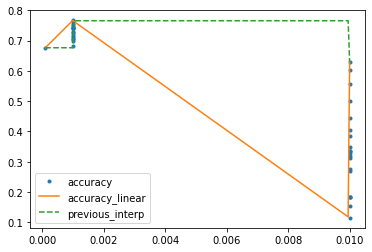

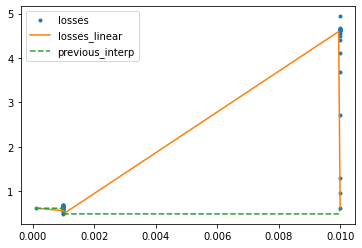

In [18]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

lrs = []
val_accs = []
val_losses = []
train_losses = []

for el in pars:
  lrs.extend(el[0])
  val_accs.append(el[1])
  val_losses.append(el[2])
  train_losses.append(el[3])
f_accs_1 = interp1d(lrs, val_accs)
f_accs_2 = interp1d(lrs, val_accs, kind='previous')

f_losses_1 = interp1d(lrs, val_losses)
f_losses_2 = interp1d(lrs, val_losses, kind='previous')

xnew = np.linspace(min(lrs), max(lrs), num=200, endpoint=True)

plt.plot(lrs, val_accs, '.', xnew, f_accs_1(xnew), '-', xnew, f_accs_2(xnew), '--')
plt.legend(['accuracy', 'accuracy_linear', 'previous_interp'], loc='best')
plt.show()
plt.plot(lrs, val_losses, '.', xnew, f_losses_1(xnew), '-', xnew, f_losses_2(xnew), '--')
plt.legend(['losses', 'losses_linear', 'previous_interp'], loc='best')



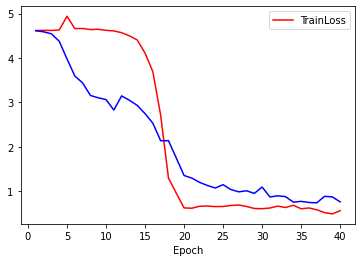

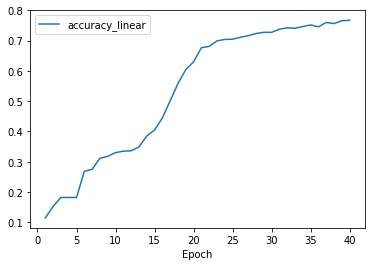

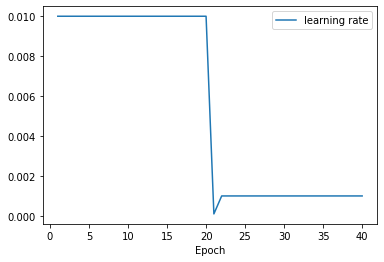

In [19]:
epoch +=1
x_epochs = np.linspace(1,epoch,epoch)

plt.plot(x_epochs, val_losses, '-', color='red')
plt.xlabel("Epoch")
plt.legend(['ValLoss'])
plt.plot(x_epochs, train_losses, '-', color='blue')
plt.xlabel("Epoch")
plt.legend(['TrainLoss'])

plt.show()

plt.plot(x_epochs, val_accs, '-')
plt.xlabel("Epoch")
plt.legend(['accuracy_linear'])
plt.show()
plt.plot(x_epochs, lrs, '-')
plt.xlabel("Epoch")
plt.legend(['learning rate'])


## Validation

In [20]:
alexNet = best_model
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
alexNet.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = alexNet(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 13/13 [00:10<00:00,  1.21it/s]

Validation Accuracy: 0.7613967022308439


## Test

In [21]:
alexNet = alexNet.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
alexNet.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = alexNet(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Test Accuracy: 0.7521603871413758
